<a href="https://colab.research.google.com/github/yilewang/TVB_Demo/blob/master/sim1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
# %pip install tvb-library
# %pylab inline
import os
from tvb.simulator.lab import *
LOG = get_logger('demo')
import pickle as cPickle
from tvb.simulator.models.stefanescu_jirsa import ReducedSetBase, ReducedSetHindmarshRose
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# %%capture
#! wget -c -O 0306A.zip --no-check-certificate https://github.com/yilewang/tvbdemos/raw/master/tvb_slurm/0306A.zip
path = "c:/Users/wayne/tvb/tvbdemos/tvb_slurm/0306A.zip"
print(path)

c:/Users/wayne/tvb/tvbdemos/tvb_slurm/0306A.zip


In [3]:
connectivity.speed = np.array([10.])
sim_time = 1e3
ReducedSetBase.number_of_modes = 1
sim = simulator.Simulator(
    model=ReducedSetHindmarshRose(variables_of_interest = ['xi']),
    connectivity=connectivity.Connectivity.from_file(path),             
    coupling=coupling.Linear(a=np.array([0.015])),
    simulation_length=sim_time,
    integrator=integrators.HeunStochastic(dt=0.01220703125, noise=noise.Additive(nsig=np.array([0.00001]), ntau=0.0,
                                                                                random_stream=np.random.RandomState(seed=42))),
    monitors=(
       monitors.TemporalAverage(period=1.),
       monitors.Raw(),
       monitors.ProgressLogger(period=1e2)
    )
).configure()
sim.configure()

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 0f71793a-fe00-4242-9e29-e79b190e2c73
coupling,Linear gid: 78fcc355-c975-45ed-87a5-f55c94ec1e4b
gid,UUID('9435c7ff-011d-42ad-8a3e-22c7a3bfdae5')
initial_conditions,None
integrator,HeunStochastic gid: 0b11805f-82ba-412f-a560-17cccdc0c732
model,ReducedSetHindmarshRose gid: f1670ae3-d8e4-418f-80c5-50d51c040c71
monitors,"(, , )"
simulation_length,1000.0


In [4]:
(tavg_time, tavg_data), (raw_time, raw_data),_ = sim.run()

   INFO  step 1 time 0.0000 s
   INFO  step 8193 time 0.1000 s
   INFO  step 16385 time 0.2000 s
   INFO  step 24577 time 0.3000 s
   INFO  step 32769 time 0.4000 s
   INFO  step 40961 time 0.5000 s
   INFO  step 49153 time 0.6000 s
   INFO  step 57345 time 0.7000 s
   INFO  step 65537 time 0.8000 s
   INFO  step 73729 time 0.9000 s


In [13]:
import h5py
hdf = h5py.File('C:/Users/wayne/Desktop/0306A.h5', 'w')
hdf.create_dataset('raw', data = raw_data[:,0,:,0])
hdf.close()

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'C:/Users/wayne/Dekstop/0306A.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [12]:
with h5py.File('0306A.h5', "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    print(np.shape(f['raw']))

Keys: <KeysViewHDF5 ['raw']>
(81920, 16)


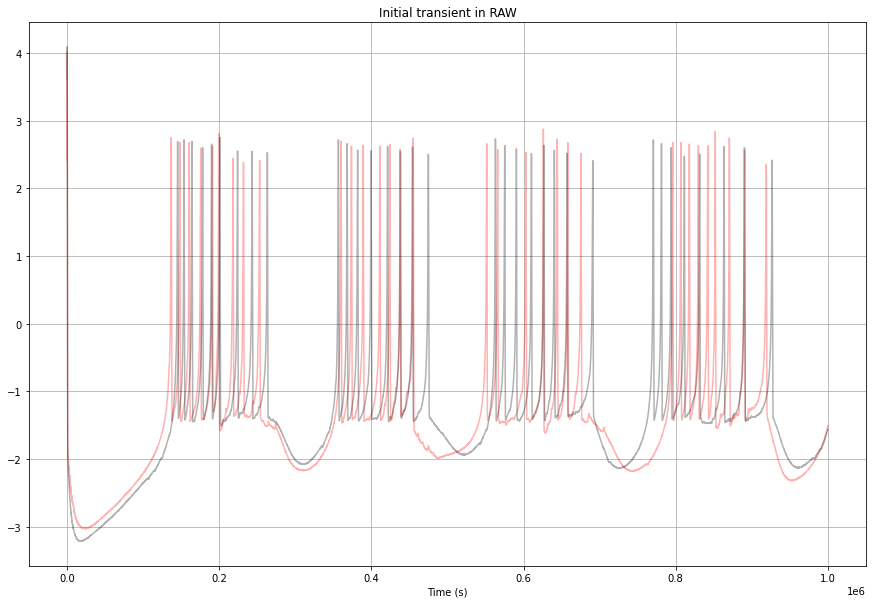

In [6]:
plt.figure(figsize=(15, 10))
plt.plot(raw_time * sim_time, raw_data[:, 0, 4, 0], "r", alpha=0.3)
plt.plot(raw_time * sim_time, raw_data[:, 0, 5, 0], "k", alpha=0.3)
plt.title('Initial transient in RAW')
plt.xlabel('Time (s)')
plt.grid(True);

In [7]:
from scipy import signal
def fir_bandpass(data, fs, cut_off_low, cut_off_high, width=2.0, ripple_db=10.0):
    """
    The FIR bandpass filter
    """
    nyq_rate = fs / 2.0
    wid = width/nyq_rate
    N, beta = signal.kaiserord(ripple_db, wid)
    taps = signal.firwin(N, cutoff = [cut_off_low, cut_off_high],
                  window = 'hamming', pass_zero = False, fs=fs)
    filtered_signal = signal.lfilter(taps, 1.0, data)
    return filtered_signal, N

ValueError: x and y must have same first dimension, but have shapes (819200,) and (81920,)

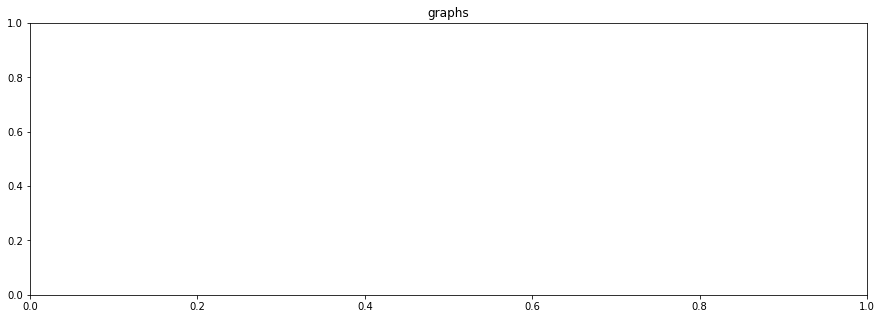

In [8]:
fs = 81920.0
samplinginterval = 1/fs
tt = np.arange(0, 10, samplinginterval)
rightTheta, N = fir_bandpass(raw_data[:,0,4,0], fs, 2.0, 10.0)
rightGamma, N = fir_bandpass(raw_data[:,0,4,0], fs, 30.0, 100)
delay = (N-1)/(2*fs)
# visualization
fig = plt.figure(figsize=(15,5))
plt.title("graphs")
plt.plot(tt, raw_data[:,0,4,0], label = "raw")
# plt.plot(raw_time[N-1:]-delay, rightGamma[N-1:], label = "35-100")
plt.plot(tt[N-1:]-delay, rightTheta[N-1:], label = "2-10")
#plt.axis(xmin=0, xmax=1)
plt.legend()
plt.show()

In [ ]:
afterRe = signal.resample(rightGamma, 10000)
f, t, Z = signal.stft(afterRe, fs=1000, window='hann', nperseg=256)
Z = np.abs(Z)
plt.figure(figsize = (10,5))
plt.pcolormesh(t, f, Z, vmin = 0, vmax = Z.mean()*10, shading="auto")
plt.axis(ymin=0, ymax=150)
plt.xlabel('Time')
plt.ylabel('Frequency')

In [ ]:
afterRe = signal.resample(rightTheta, 1000)
f, t, Z = signal.stft(afterRe, fs=100, window='hann', nperseg=256)
Z = np.abs(Z)
plt.figure(figsize = (10,5))
plt.pcolormesh(t, f, Z, vmin = 0, vmax = Z.mean()*10, shading="auto")
plt.axis(ymin=0, ymax=150)
plt.xlabel('Time')
plt.ylabel('Frequency')